# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [285]:
# Load pickled data
import pickle
import numpy as np

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [286]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
n_classes = max(y_train)+1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


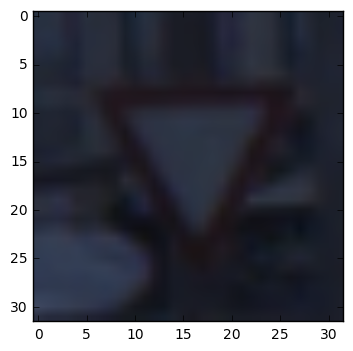

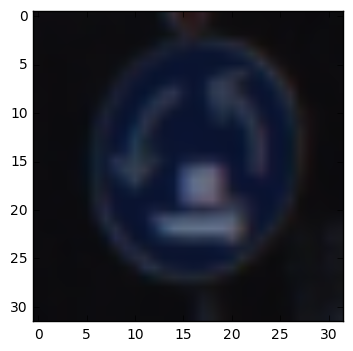

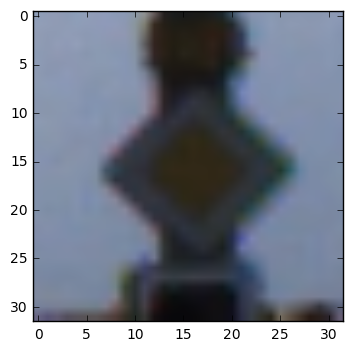

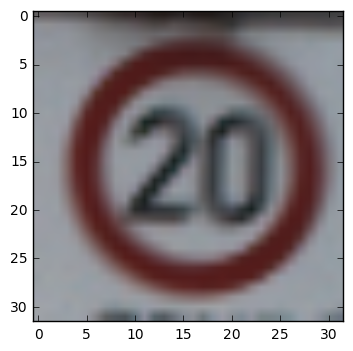

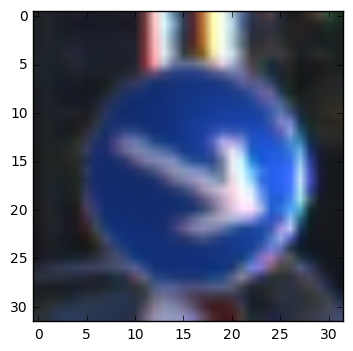

In [287]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

%matplotlib inline

for i in range(5):
    plt.imshow(X_train[random.randint(0,len(X_train-1))])
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [288]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import numpy as np
from skimage.color import rgb2gray
from skimage import exposure 
from tqdm import tnrange, tqdm_notebook, tqdm

def equalize_exposure(images):
    ret = []
    for i in tnrange(images.shape[0]):
        ret.append(exposure.equalize_adapthist(images[i]))
    
    return np.asarray(ret)

X_train_norm = equalize_exposure(X_train)
X_test_norm = equalize_exposure(X_test)

X_train_norm = rgb2gray(X_train_norm)/255.0
X_test_norm = rgb2gray(X_test_norm)/255.0


/home/miro/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [289]:
X_train_norm = X_train_norm.reshape([-1,32,32,1])
X_test_norm = X_test_norm.reshape([-1,32,32,1])

num_channels = 1

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
I first normalized the data to be in range 0 to 1. This helps in learning as the gradients are more stable with less volatility. Next I tried converting the images to grayscale as suggested in the paper which improved performance on the validation set. It seems that the color information is not essential to the recognition and shape is more important to make the distinction. Finally, I tried to normalize the exposure. When looking at the images I noticed that some are very dark and others are overly exposed. This resulted in better performance and with longer training I was able to go above 90% accuracy.  

In [290]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import numpy as np 

train_size = int(0.8*n_train)
indices = np.random.permutation(X_train.shape[0])
training_idx, val_idx = indices[:train_size], indices[train_size:]

X_train_set, y_train_set = X_train_norm[training_idx], y_train[training_idx]
X_val_set, y_val_set = X_train_norm[val_idx], y_train[val_idx]

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I split the training and validation set 80:20. I was making my architecture and hyper parameter optimizations on my validation set and left the final check to the test set. 
I also shuffled in case that there are positional dependencies between images and classes.

In [291]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

def conv2d(X, filter_size, num_filters, stride=1, padding='SAME', activation_fn=tf.nn.relu):
    channels = X.get_shape().as_list()[-1]
    W = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, channels, num_filters]))
    b = tf.Variable(tf.zeros([num_filters]))
    conv = tf.nn.conv2d(X, W, strides=[1,stride, stride,1], padding=padding)
    layer = tf.nn.bias_add(conv, b)
    pool = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    return activation_fn(pool)

def linear(X, n_outputs):
    n_inputs = X.get_shape().as_list()[1]
    W = tf.Variable(tf.truncated_normal([n_inputs, n_outputs]))
    b = tf.Variable(tf.zeros([n_outputs]))
    
    return tf.nn.bias_add(tf.matmul(X, W), b)

X = tf.placeholder(tf.float32, shape=[None, 32, 32,num_channels])
y = tf.placeholder(tf.int64, shape=[None])
keep_prob = tf.placeholder(tf.float32)
#CONV layer
layer = conv2d(X, 5, 24)
layer = tf.nn.dropout(layer, keep_prob)
layer = conv2d(layer, 5, 32)
layer = tf.nn.dropout(layer, keep_prob)
conv1 = tf.contrib.layers.flatten(layer)

layer = conv2d(layer, 5, 64)
layer = tf.nn.dropout(layer, keep_prob)
conv2 = tf.contrib.layers.flatten(layer)
conv_layer = tf.concat(1, [conv1, conv2])

#FC layer
fc_layer = tf.nn.relu(linear(conv_layer, 200))
y_pred = linear(fc_layer, n_classes)

#reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-5), tf.trainable_variables())

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, y))#+reg

correct = tf.equal(y, tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

learning_rate=1e-4
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The architecture is is a convolutional neural network followed by a fully connected layer. I chose convolutional neural network because it has proven to have much better performance than normal fully connected network on vision related task. 
It consists of 3 convolutional layers with number of filters[24, 32, 64]
Each convolution is with strides 1 and is followed by a max pool operation with relu activation and a dropout layer. I chose relu activation as it seems that it is preferred and gives better results. The sigmoid and tanh nonlinearities have a downside as they may get saturated and stop learning. I also decided to add drop out because the network was overfitting the training set and I was getting close to 100% very quickly after learning. This made me think that I will get better results on the test set if I add dropout and force the network to have redundancies.
The network takes the input after the 2nd convolution and 3rd convolution concatenates them together and feeds it to the fully connected layer which has 200 units. This is similar to the way it is done in the provided paper. 
After that it is fed to the output layer that returns a vector which has number of classes dimensions.

The costs function is a softmax cross entropy

In [292]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

val_accuracies = []
train_accuracies = []
train_costs = []
val_acc = 0
train_acc = 0

In [312]:
### Train your model here.
### Feel free to use as many code cells as needed.

num_epochs = 400
batch_size = 100
batches = len(X_train_set)//batch_size

for i in tnrange(num_epochs, desc='Epoch'):
    for b in range(batches):
        cur = b*batch_size
        X_train_batch = X_train_set[cur: cur+batch_size]
        y_train_batch = y_train_set[cur: cur+batch_size]
        feed_dict={X:X_train_batch, y:y_train_batch, keep_prob:0.7}
        _, train_acc, train_cost = sess.run([optimizer, accuracy, cost],feed_dict=feed_dict)

        if (b + 1) % 100 == 0:
            val_acc = sess.run([accuracy], feed_dict={X:X_val_set, y:y_val_set, keep_prob:1.0})
            train_accuracies.append(train_acc)
            train_costs.append(train_cost)
            val_accuracies.append(val_acc)


Validation accuracy: [0.95868438]
Train accuracy: 0.949999988079071
Test set accuracy: [0.88266075]


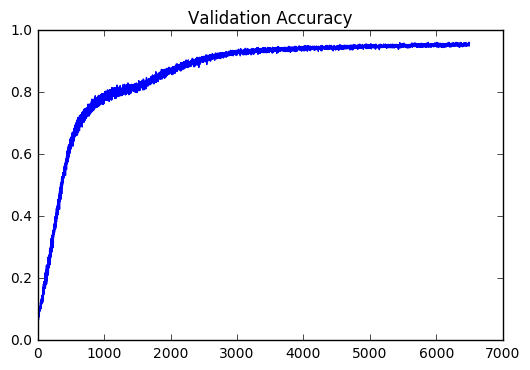

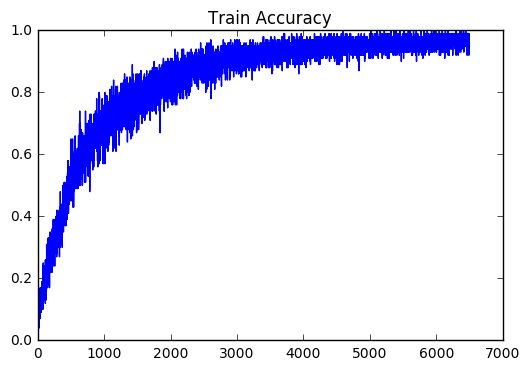

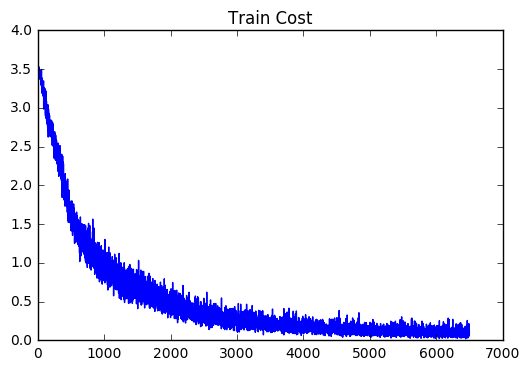

In [313]:
print('Validation accuracy: {}'.format(val_acc))
print('Train accuracy: {}'.format(train_acc))
acc = sess.run([accuracy], feed_dict={X:X_test_norm, y:y_test, keep_prob:1.0})
print('Test set accuracy: {}'.format(acc))

plt.plot(val_accuracies[100:])
plt.title('Validation Accuracy')
plt.show()
plt.plot(train_accuracies[100:])
plt.title('Train Accuracy')
plt.show()
plt.plot(train_costs[100:])
plt.title('Train Cost')
plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I am using 1800 epochs with batch size 100. 
I am using an Adam optimizer with learning rate 1e-4
I am using a dropout value of 0.7 during training. 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I decided to do a convolutional neural network followed by a fully connected layers.
After a lot of tinkering I ended up with 3 convolutional layers and one fully connected layer.
I also added drop out because the network was over fitting the training data. I also saw significant improvement when I normalized the exposure. I tried adding more than one fully connected layer but it didn't prove beneficial.
I tried using a dropout of 0.5 but that also made prediction worse. I also adopted some of the ideas from the provided paper specifically the skip connection.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [305]:
import csv
sign_names={}
with open('signnames.csv') as csvf:
    reader = csv.reader(csvf,delimiter=',')
    for sid,name in reader:
        if sid != 'ClassId':
            sign_names[int(sid)] = name

In [315]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
from skimage.transform import resize
import cv2
def load_image(img_path):
    img = plt.imread(img_path)
    return cv2.resize(img, (32,32))

def load_images(folder):
    images = [load_image(folder+file) for file in os.listdir('data/') if file.endswith('.jpg')]
    res = np.zeros([len(images), 32, 32,3], dtype='uint8')
    for i, img in enumerate(images):
        res[i] = img
    return res

signs = load_images('data/')
signs_eq = equalize_exposure(signs)

/home/miro/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
I see a some issues in my test images.
1. When the sign is not centered on the image. 
2. On signs that are not part of the training set.
3. The rescaling of the images is very important to produce similar looking results. 

In [316]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
signs_norm = rgb2gray(signs_eq).reshape([-1, 32,32,1])/255.0
predictions = sess.run([y_pred], feed_dict={X:signs_norm.reshape([-1,32,32,1]), keep_prob:1.0})
predicted_labels = np.argmax(np.asarray(predictions).squeeze(), axis=1)

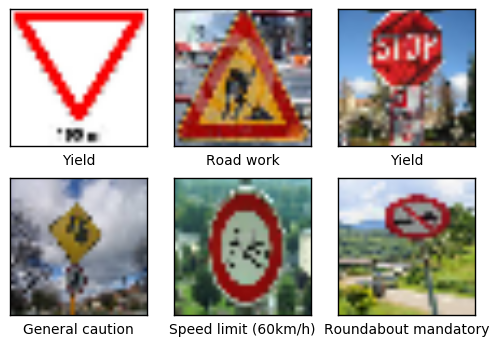

In [317]:
fig, axes = plt.subplots(2, 3)
for i, ax in enumerate(axes.flat):
    ax.imshow(signs[i])
    ax.set_xlabel(sign_names[predicted_labels[i]])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**
No the model does not perform as well on captured images. I am only getting about 30% correct predictions on my set compared to close to 90% on the provided test set.  

One of the reasons could be that the resizing is not producing similar images to the test set. 

In [309]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
indexes = np.random.choice(X_test.shape[0], 6)
test_images = X_test[indexes]
predictions = sess.run([y_pred], feed_dict={X:X_test_norm[indexes], keep_prob:1.0})
predicted_labels = np.argmax(np.asarray(predictions).squeeze(), axis=1)

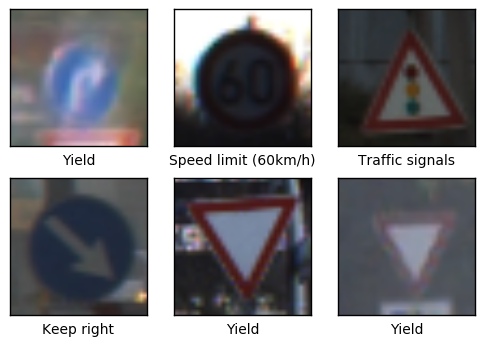

In [310]:
fig, axes = plt.subplots(2, 3)
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.set_xlabel(sign_names[predicted_labels[i]])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
For some of the predictions the right label appers, but for a couple of my test images the correct labels do not. When the correct label is not the top choice the uncertenty is spread out. 

For some predictions the right label appears, but for a couple of my test images the correct labels do not.When the correct label is not the top choice the uncertainty is spread out. 

1. For the first image the model is very certain that it is a yield sign it gives it a probability of 100%
2. For the second image the model is also very certain and gives 99% probability that it is road work
3. For the third image the model is very uncertain giving about 30% probability for the top 3 picks which are all wrong. This is clearly a stop sign and it is very surprising that it doesn't recognize it as such. My guess is that the sharp shadows on top of it and the fact that it is off center are breaking the prediction. 
4. The fourth image is also misclassified again with a lot of uncertainty. This sign is not in the training set so it is not unusual that it gets it miss classified.
5. The fifth image is also miss-classified it gives it a certainty of 64% for being a speed limit of 60Km/h. This is not very high certainty but it seems that is more certain that the other misclasified images. I think the resizing is breaking this classification as the picture looks very jagged compared to the images in the test set where the images there are much softer. The images need a better resizing algorithm but opencv and scipy both produced similar results. 
6. The last image is also misclassified with the correct label not appearing in the suggested results.The probability is also spread out between the first two picks. I think that the fact that the sign is not centered is breaking the prediction.

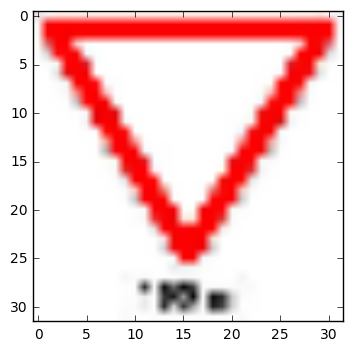

Yield : 1.0
Ahead only : 3.00584791523343e-29
Speed limit (30km/h) : 7.750934401525427e-30
Priority road : 4.109868673638715e-30
Keep right : 2.7890140079474166e-30


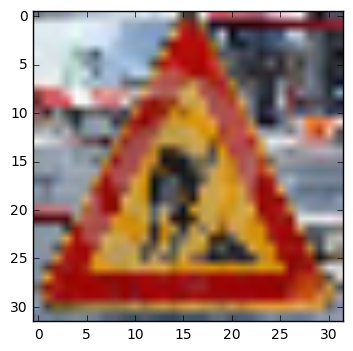

Road work : 0.9935188889503479
Dangerous curve to the right : 0.002341583836823702
Right-of-way at the next intersection : 0.001761311898007989
General caution : 0.001625782111659646
Double curve : 0.00039608319639228284


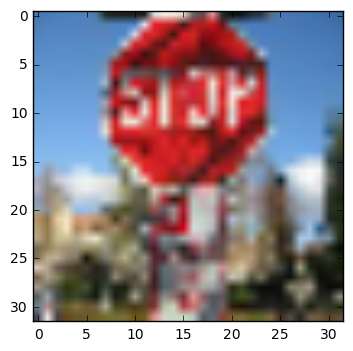

Yield : 0.31108734011650085
Roundabout mandatory : 0.2734139859676361
Go straight or right : 0.23624034225940704
Keep right : 0.16725781559944153
Ahead only : 0.00342040928080678


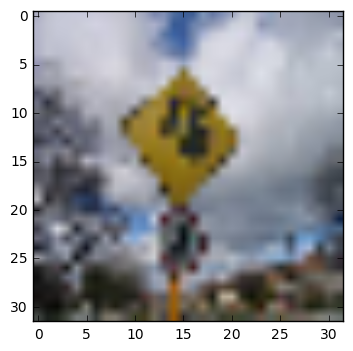

General caution : 0.34917569160461426
Traffic signals : 0.19957110285758972
Yield : 0.12213078141212463
Roundabout mandatory : 0.11719942837953568
Right-of-way at the next intersection : 0.08386261761188507


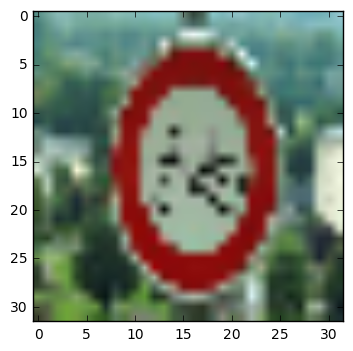

Speed limit (60km/h) : 0.6422556042671204
Speed limit (50km/h) : 0.2871471047401428
Speed limit (70km/h) : 0.03396338224411011
Speed limit (30km/h) : 0.022660139948129654
Speed limit (80km/h) : 0.013351975940167904


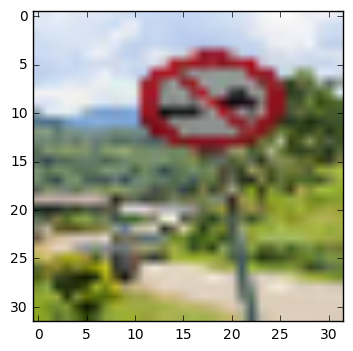

Roundabout mandatory : 0.6204439401626587
Keep right : 0.247092142701149
Priority road : 0.08359396457672119
Right-of-way at the next intersection : 0.043525148183107376
Go straight or right : 0.0017163855955004692


In [314]:
softmax = tf.nn.softmax(y_pred)
top_five = tf.nn.top_k(softmax, k = 5)

index = np.random.choice(signs_norm.shape[0], 1)
predictions = sess.run(top_five, feed_dict={X:signs_norm, keep_prob:1.0})
predicted_labels = predictions.indices.squeeze()
probabilities =  predictions.values.squeeze()
for i in range(signs.shape[0]):
    plt.imshow(signs[i].squeeze())
    plt.show()
    
    for j in range(5):
        predicted_label = predicted_labels[i][j]
        prob = probabilities[i][j]
        print('{} : {}'.format(sign_names[predicted_label], prob))



### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.